In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale 
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV, StratifiedKFold,cross_val_score

In [4]:
#housing = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
housing = pd.read_csv("train.csv")
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(housing.shape)

(1460, 81)


In [6]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Missing values analysis

In [7]:
# Cheching missing values
def check_null(housing):
    missingValues= housing.isnull().sum()
    missingValues_percentage = housing.isnull().sum() / len(housing) * 100
    missing_values_df = pd.concat([missingValues,missingValues_percentage], axis=1)
    missing_values_df.rename(columns = {0: 'NA Count', 1: 'Missing Percentage'}, inplace = True)
    missing_values_df.sort_values(by=['Missing Percentage'], ascending=False,inplace=True)
    return missing_values_df[missing_values_df['Missing Percentage']>0]

In [8]:
null_df = check_null(housing)
null_df.head(80)

,NA Count,Missing Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [9]:
# Dropping columns having more than 30% null values
housing = housing.drop(['PoolQC','MiscFeature', 
                  'Alley','Fence','FireplaceQu'], axis=1)

In [10]:
# Number of features in detaset
numeric_columns = housing.select_dtypes(include=np.number).columns.tolist()
print('numerical features: {}'.format(str(len(numeric_columns))))
categorical_columns = housing.select_dtypes(include=object).columns.tolist()
print('Categorical features: {}'.format(str(len(categorical_columns))))

numerical features: 38
Categorical features: 38


### Feature engineering

#### Categorical variables

In [11]:
for i in categorical_columns:
    print("{}: value counts in percentage ..........".format(i))
    print(housing[i].value_counts() / len(housing))
    print("")

MSZoning: value counts in percentage ..........
RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64

Street: value counts in percentage ..........
Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64

LotShape: value counts in percentage ..........
Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

LandContour: value counts in percentage ..........
Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64

Utilities: value counts in percentage ..........
AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64

LotConfig: value counts in percentage ..........
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64

LandSlope: value counts in percentage ..........
Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dt

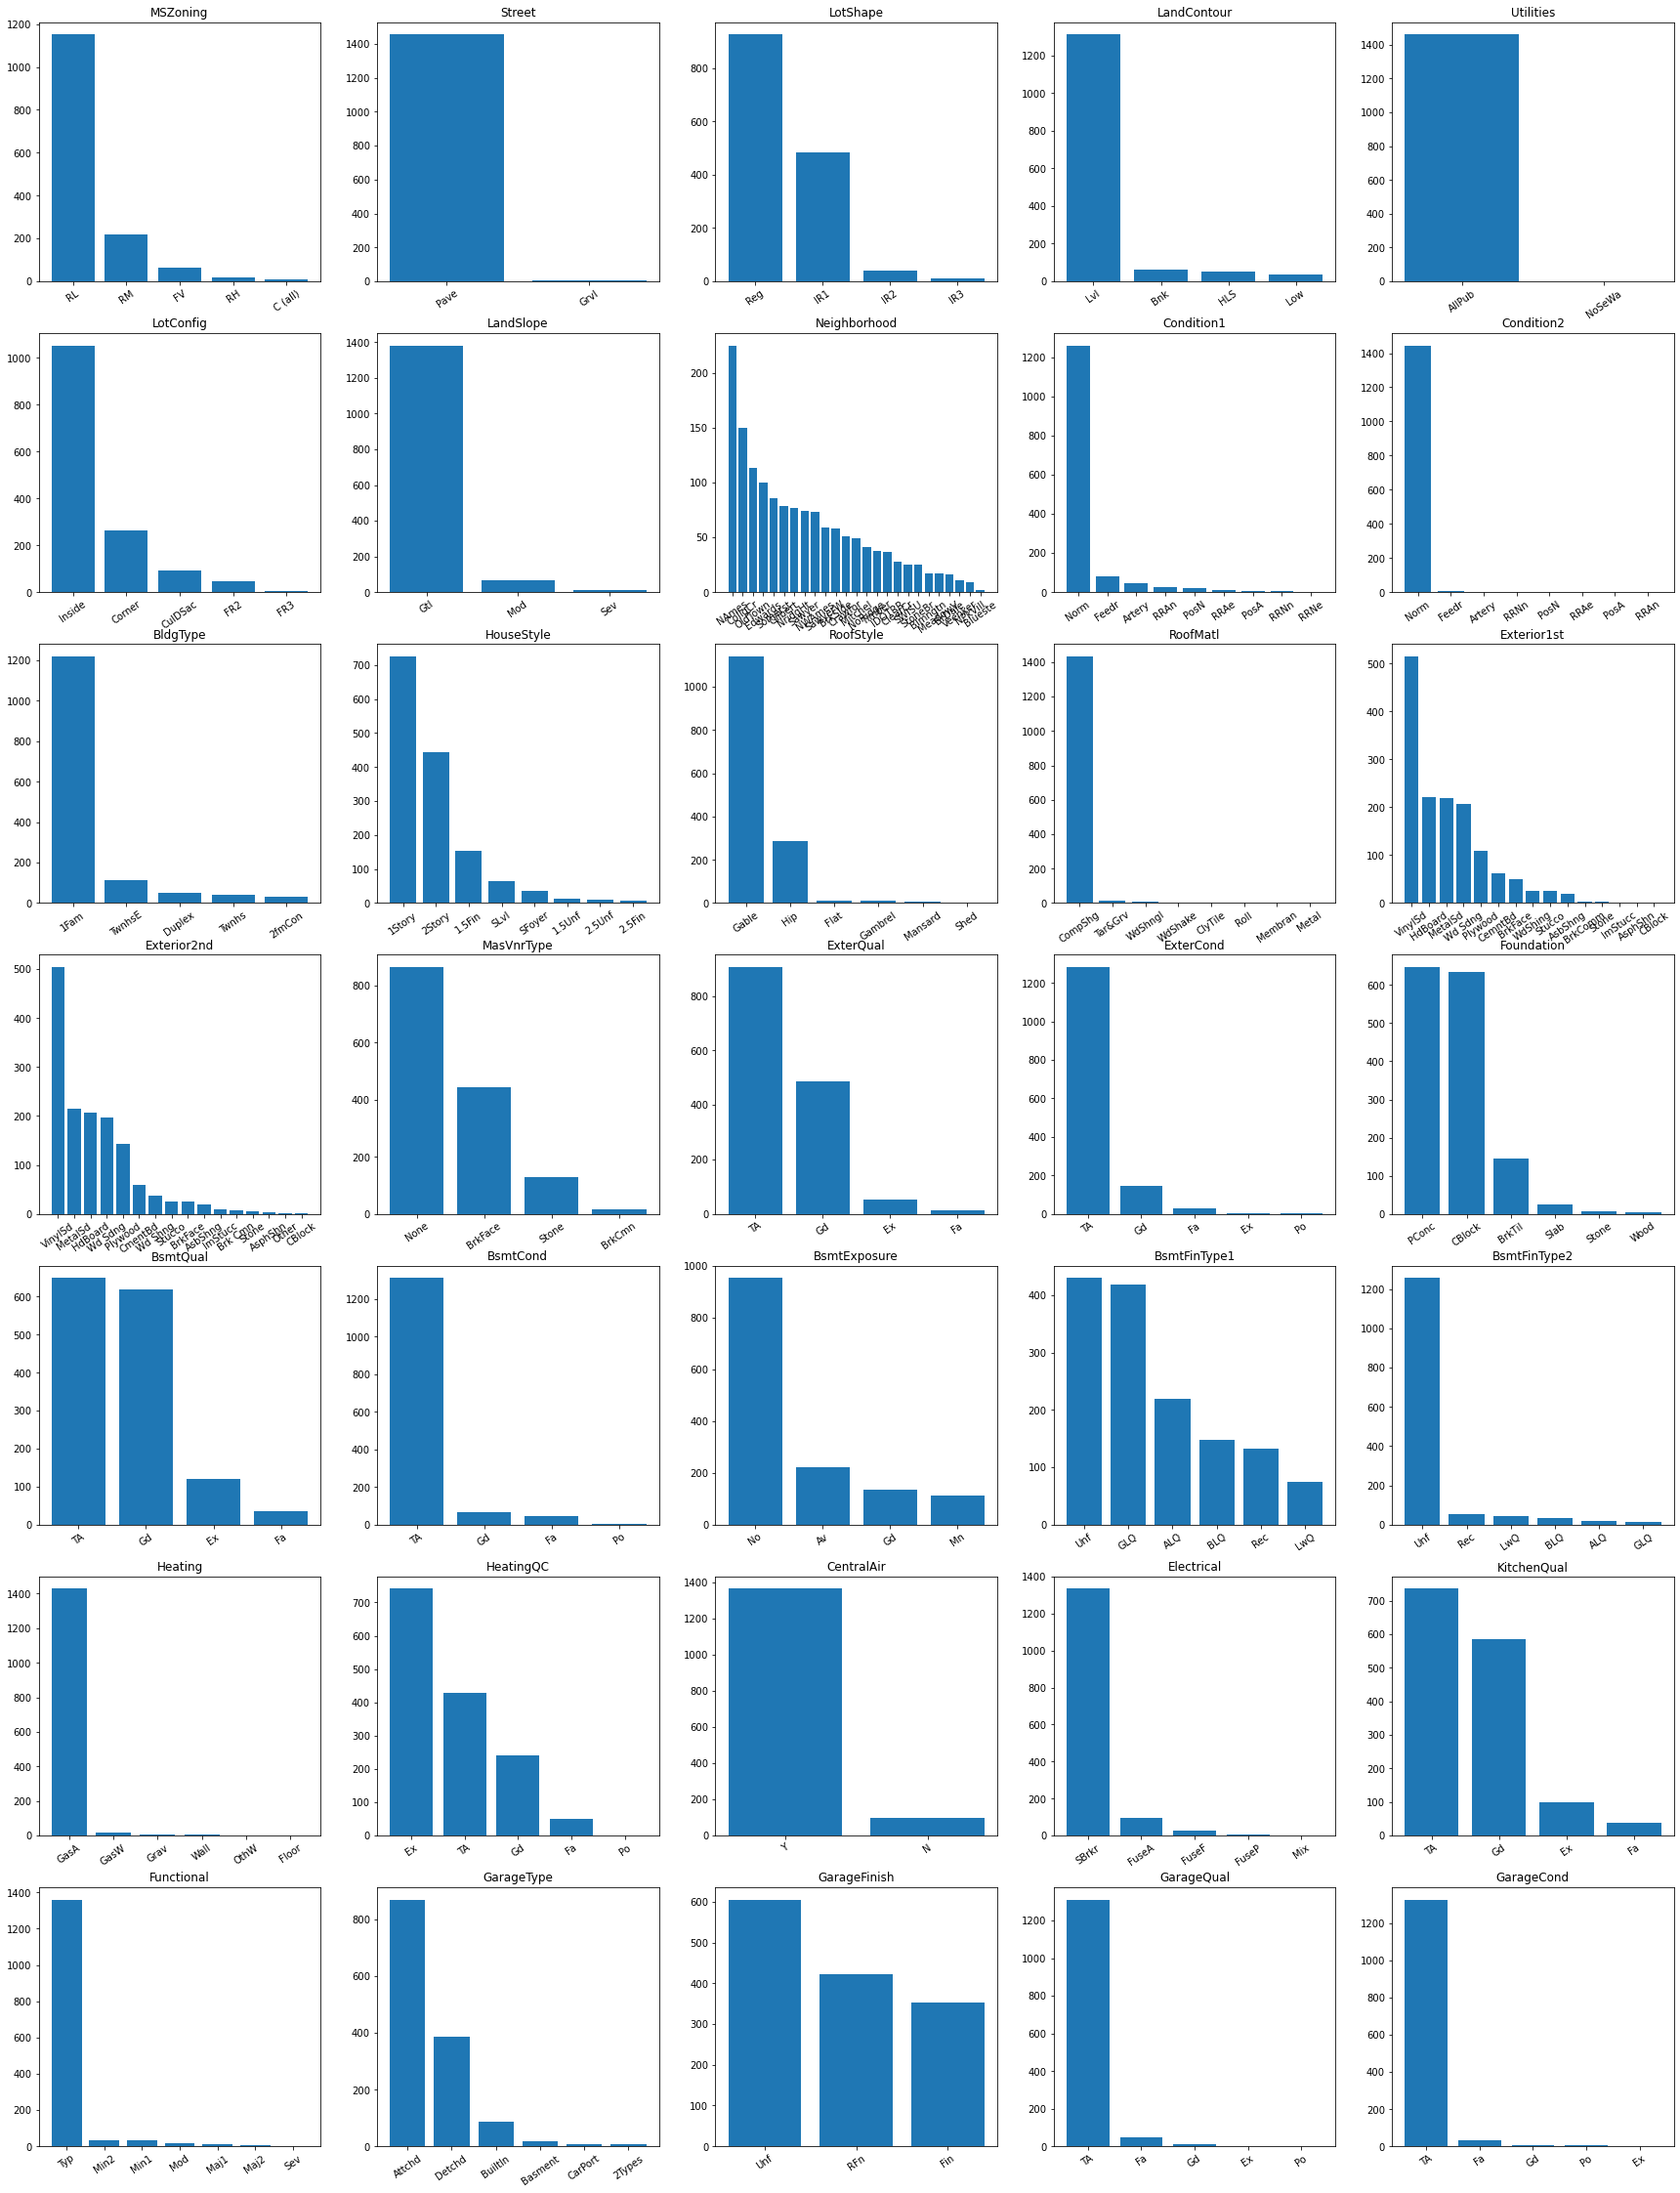

In [12]:
fig, axs = plt.subplots(len(categorical_columns)//5, 5, figsize=(30, 40))
for col, ax in zip(categorical_columns, axs.flatten()):
    y = housing[col].value_counts()
    ax.bar(y.index, y.values)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
plt.show()

In [13]:
housing = housing.drop(['Street','Utilities','LandSlope','Condition1'
,'Condition2','BldgType','RoofStyle'
,'BsmtFinType2','Heating','CentralAir','Electrical','Functional',
'GarageQual','PavedDrive','SaleType','SaleCondition'], axis=1)

In [14]:
# Number of features in detaset
numeric_columns = housing.select_dtypes(include=np.number).columns.tolist()
print('numerical features: {}'.format(str(len(numeric_columns))))
categorical_columns = housing.select_dtypes(include=object).columns.tolist()
print('Categorical features: {}'.format(str(len(categorical_columns))))

numerical features: 38
Categorical features: 22


#### Numeric variables

In [15]:
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

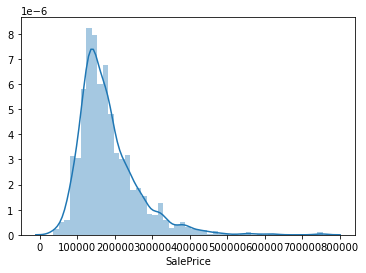

In [16]:
sns.distplot(housing['SalePrice'])
plt.show()

In [17]:
print("Skewness: %f" % housing.SalePrice.skew())
print("Kurtosis: %f" % housing.SalePrice.kurt())

Skewness: 1.882876
Kurtosis: 6.536282


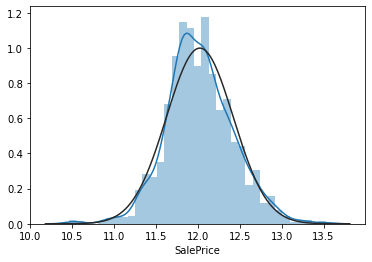

In [18]:
#log transformation to remove skewness
housing.SalePrice = np.log1p(housing.SalePrice)
sns.distplot(housing.SalePrice, fit=norm )
plt.show()

#### Correlation analysis

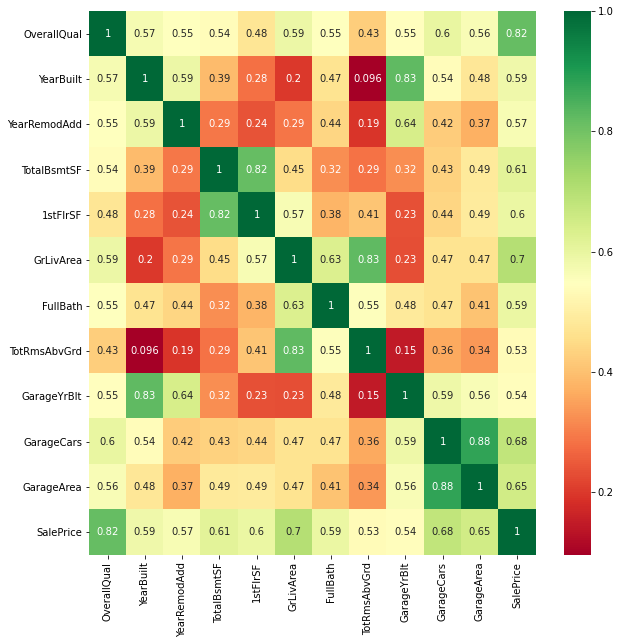

In [19]:
corrmat = housing.corr()
highly_correlated_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(housing[highly_correlated_features].corr(),annot=True,cmap="RdYlGn")

#### `Inferences`
- OverallQual is having highest correlation with SalePrice i.e. 0.82
- 1stFlrSF and TotalBsmtSF are correlated with 0.82
- GarageCars and GarageArea are correlated with 0.88
- TotRmsAbvGrd & GrLivArea are highly correlated with 0.83.

In [20]:
print(highly_correlated_features)

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')


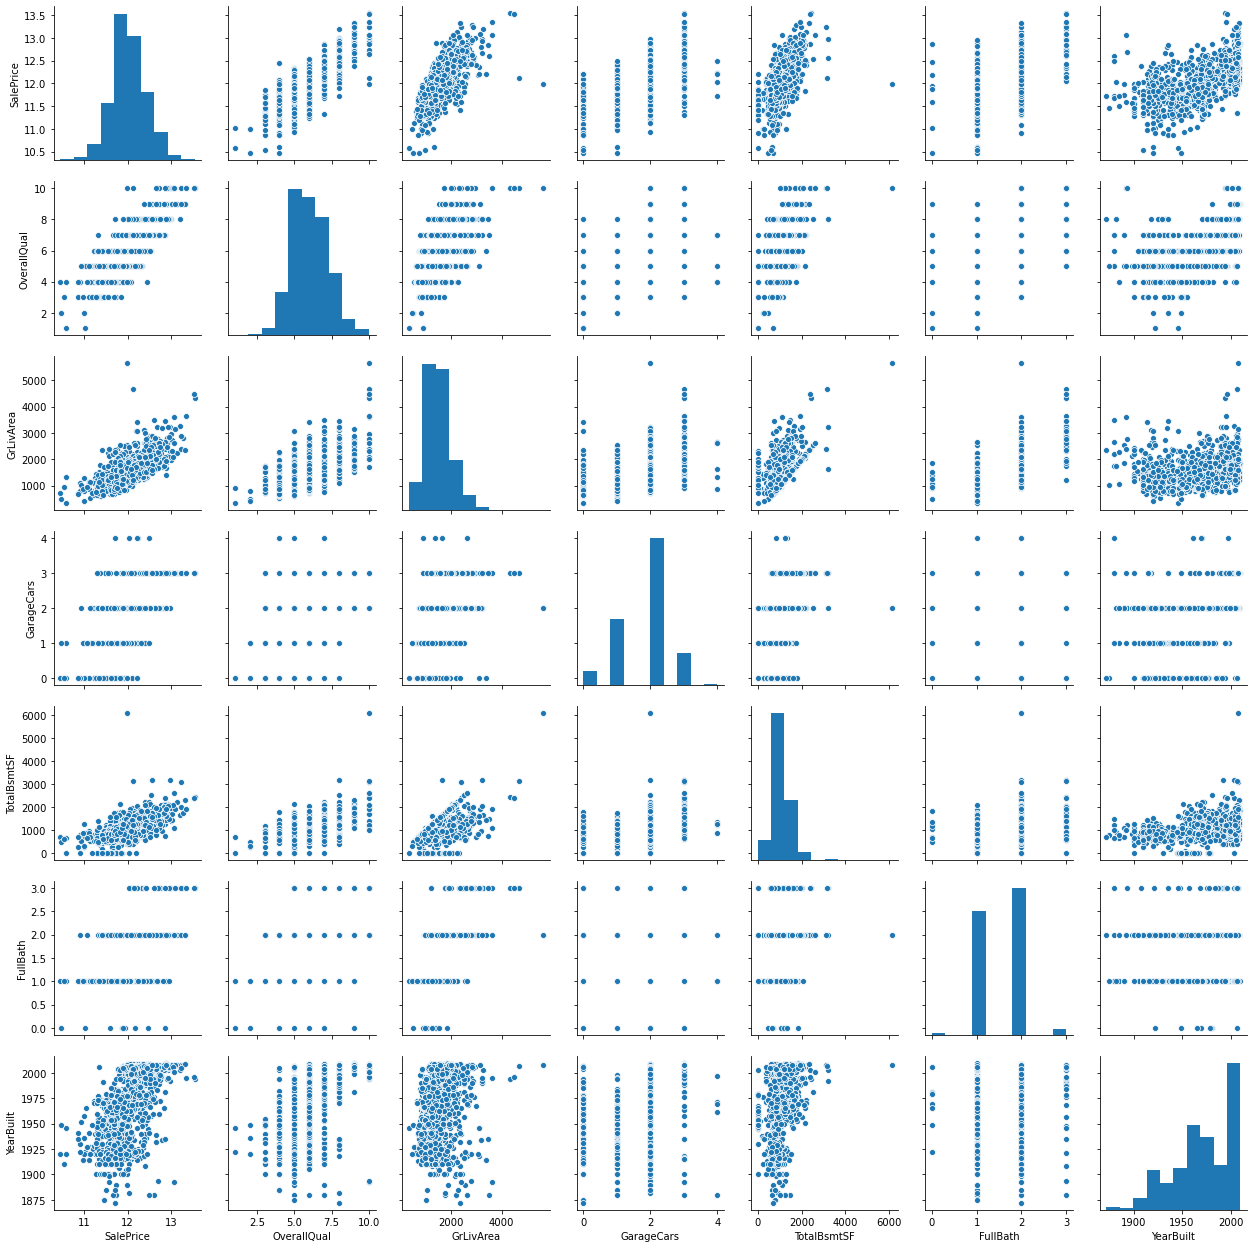

In [21]:
# visualizing highly correlated variables.
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(housing[cols])
plt.show()

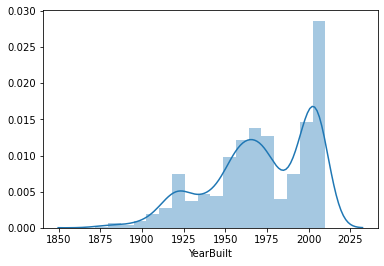

In [22]:
sns.distplot(housing['YearBuilt'])


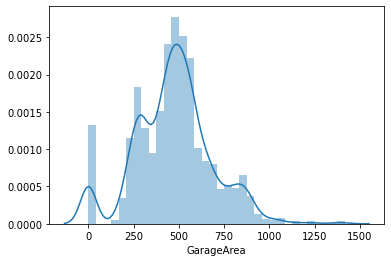

In [23]:
sns.distplot(housing['GarageArea'])


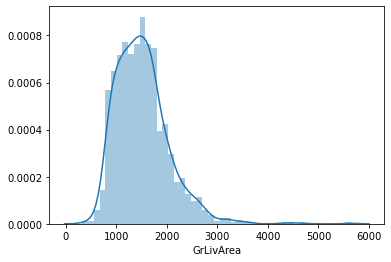

In [24]:
sns.distplot(housing['GrLivArea'])


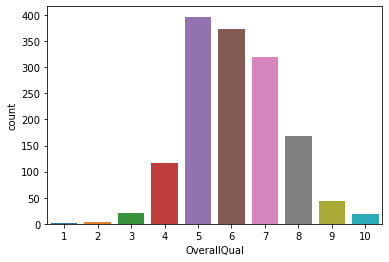

In [25]:
sns.countplot(housing['OverallQual'])

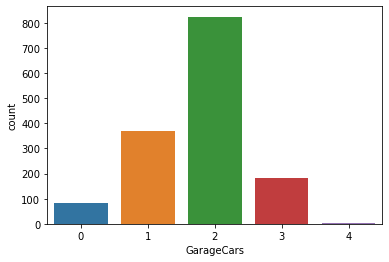

In [26]:
sns.countplot(housing['GarageCars'])


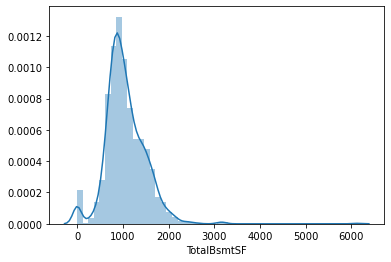

In [27]:
sns.distplot(housing['TotalBsmtSF'])


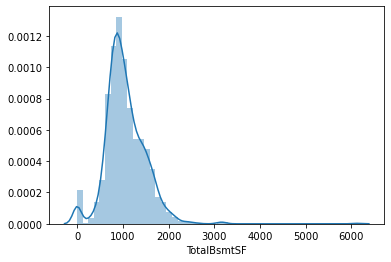

In [28]:
sns.distplot(housing['TotalBsmtSF'])


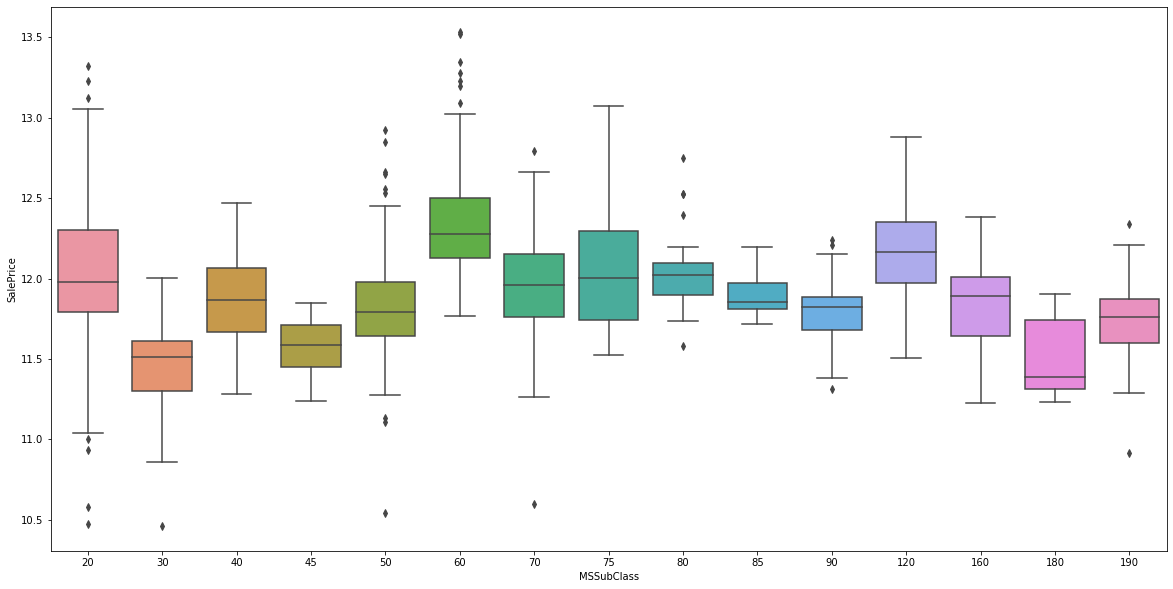

In [29]:
plt.figure(figsize = (20,10))
sns.boxplot(housing['MSSubClass'], housing['SalePrice'])

###  Handling missing values 

In [30]:
inp0 = housing.copy()
inp0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,2Story,...,0,61,0,0,0,0,0,2,2008,12.247699
1,2,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,1Story,...,298,0,0,0,0,0,0,5,2007,12.109016
2,3,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,2Story,...,0,42,0,0,0,0,0,9,2008,12.317171
3,4,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,2Story,...,0,35,272,0,0,0,0,2,2006,11.849405
4,5,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,2Story,...,192,84,0,0,0,0,0,12,2008,12.429220


In [31]:
print(inp0.shape)

(1460, 60)


In [32]:
numeric_columns = inp0.select_dtypes(include=np.number).columns.tolist()
print('numerical features: {}'.format(str(len(numeric_columns))))
categorical_columns = inp0.select_dtypes(include=object).columns.tolist()
print('Categorical features: {}'.format(str(len(categorical_columns))))

numerical features: 38
Categorical features: 22


In [33]:
for feature in numeric_columns:
    inp0[feature] = inp0[feature].fillna(0)

In [34]:
categorical_missing_features = ['GarageFinish','GarageFinish','BsmtExposure','BsmtFinType1',
                              'BsmtQual', 'MasVnrType', 'GarageType','GarageCond',
                               'BsmtCond']
for feature in categorical_missing_features:
    inp0[feature] = inp0[feature].fillna(inp0[feature].mode()[0])

In [35]:
# Again checking for missing values
null_df = check_null(inp0)
null_df.head(80)

,NA Count,Missing Percentage


### Fixing numeric data distribution.


##### Removing skewness from numeric variables

In [36]:
# List of feature with high skewness
numeric_features = inp0.dtypes[inp0.dtypes != 'object'].index
skewed_features = inp0[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewed_features = skewed_features[abs(skewed_features) > 0.5]
high_skewed_features

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -3.865524
dtype: float64

In [37]:
#log transformation to remove skewness

for feature in high_skewed_features.index:
    inp0[feature] = np.log1p(inp0[feature])

In [38]:
#### Combining house size in square feet
inp0['TotalSF'] = inp0['TotalBsmtSF'] + inp0['1stFlrSF'] + inp0['2ndFlrSF']

In [39]:
inp0['age']=inp0['YrSold']-inp0['YearBuilt']


In [40]:
inp0['MSSubClass'] = inp0[['MSSubClass']].astype(str) 
inp0['YrSold'] = inp0['YrSold'].astype(str) #year
inp0['MoSold'] = inp0['MoSold'].astype(str) #month

In [41]:
inp0.isna().sum()

Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
              ..
MoSold         0
YrSold         0
SalePrice      0
TotalSF        0
age            0
Length: 62, dtype: int64

#### Biverient analysis and outlier treatment

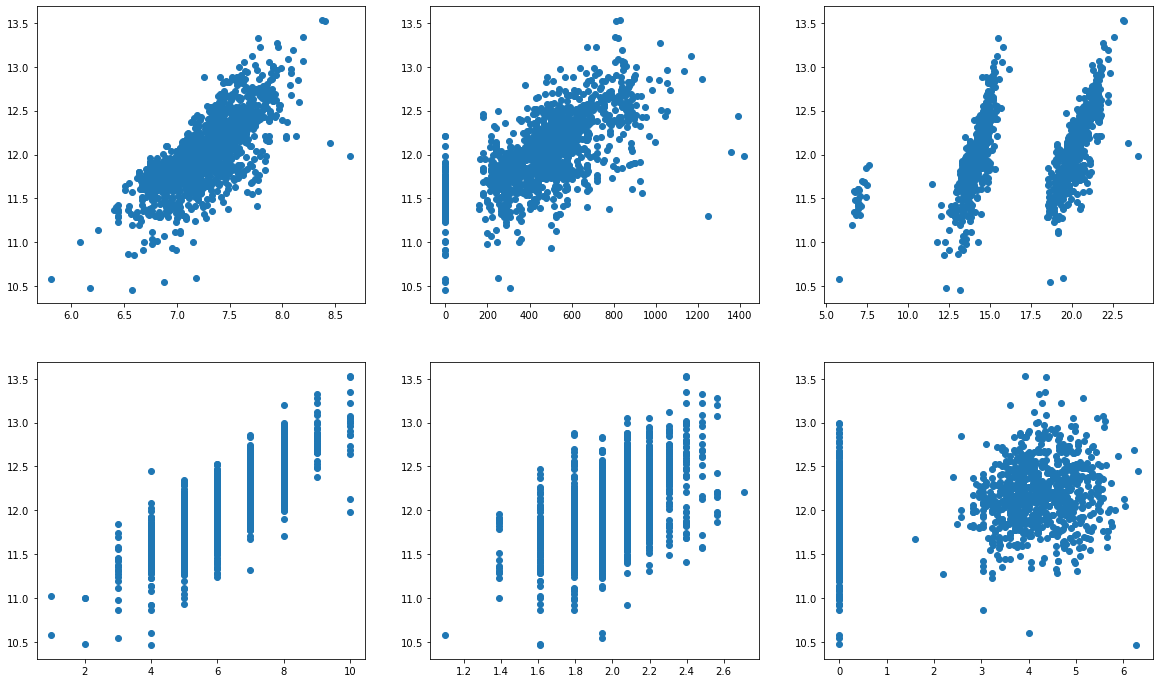

In [42]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.scatter(x=inp0['GrLivArea'], y=inp0['SalePrice'])
plt.subplot(2,3,2)
plt.scatter(x=inp0['GarageArea'],y=inp0['SalePrice'])
plt.subplot(2,3,3)
plt.scatter(x=inp0['TotalSF'],y=inp0['SalePrice'])
plt.subplot(2,3,4)
plt.scatter(x=inp0['OverallQual'],y=inp0['SalePrice'])
plt.subplot(2,3,5)
plt.scatter(x=inp0['TotRmsAbvGrd'],y=inp0['SalePrice'])
plt.subplot(2,3,6)
plt.scatter(x=inp0['OpenPorchSF'],y=inp0['SalePrice'])
plt.show()

In [43]:
# Number of features in detaset
numeric_columns = inp0.select_dtypes(include=np.number).columns.tolist()
print('numerical features: {}'.format(str(len(numeric_columns))))
categorical_columns = inp0.select_dtypes(include=object).columns.tolist()
print('Categorical features: {}'.format(str(len(categorical_columns))))

numerical features: 37
Categorical features: 25


In [44]:
from sklearn.preprocessing import OneHotEncoder
onehotencode = OneHotEncoder()

In [45]:
inp0_object = inp0.select_dtypes('object')
object_column_names = list(inp0_object.columns)
onehotencode.fit(inp0_object)
#Transforming categorical featues to an arrays
inp0_encoded = onehotencode.transform(inp0_object).toarray()
string_feature_names = onehotencode.get_feature_names(object_column_names)

In [46]:
len(object_column_names)

25

In [47]:
inp0_numeric = inp0.select_dtypes(exclude='object')
inp0_numeric = inp0_numeric.reset_index(drop=True)
numeric_column_names = inp0.select_dtypes(exclude='object').columns.tolist()

In [48]:
# Converting encoded data to dataframe
train_df =pd.DataFrame(inp0_encoded,columns=string_feature_names).astype(int)
train_df = train_df.reset_index(drop=True)

In [49]:
train = pd.concat([inp0_numeric, train_df], axis=1)
#test = pd.concat([test_num, test_converted], axis=1)

In [50]:
print(inp0.shape)

(1460, 62)


In [51]:
X = train.drop(['SalePrice', 'Id'], axis=1)
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,65.0,9.042040,7,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,5.017280,...,0,0,0,0,0,0,0,1,0,0
1,80.0,9.169623,6,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,5.652489,...,1,0,0,0,0,0,1,0,0,0
2,68.0,9.328212,7,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,6.075346,...,0,0,0,0,1,0,0,1,0,0
3,60.0,9.164401,7,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,6.293419,...,0,0,0,0,0,1,0,0,0,0
4,84.0,9.565284,8,1.791759,7.601402,7.601402,5.860786,6.486161,0.0,6.196444,...,0,0,0,0,0,0,0,1,0,0


In [52]:
# Putting response variable to y

y = train.SalePrice
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

#### Feature Scaling

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


In [54]:
#from sklearn import preprocessing
#from sklearn import utils

#lab_enc = preprocessing.LabelEncoder()
#y_train_encoded = lab_enc.fit_transform(y_train)
#print(training_scores_encoded)
#print(utils.multiclass.type_of_target(y))
#print(utils.multiclass.type_of_target(y.astype('int')))
#print(utils.multiclass.type_of_target(y_train_encoded))

In [55]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()

In [56]:
#from sklearn.feature_selection import RFE
#rfe = RFE(logreg, 110)             # running RFE with 13 variables as output
#rfe = rfe.fit(X_train, y_train_encoded)

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train

array([[0.25559105, 0.40691169, 0.66666667, ..., 1.        , 0.        ,
        0.        ],
       [0.11182109, 0.20332032, 0.44444444, ..., 0.        , 0.        ,
        0.        ],
       [0.23003195, 0.3706235 , 0.66666667, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.19169329, 0.35972389, 0.44444444, ..., 0.        , 0.        ,
        0.        ],
       [0.17571885, 0.3465999 , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.16932907, 0.20379898, 0.66666667, ..., 0.        , 1.        ,
        0.        ]])

### Build the Linear Regression Model

In [58]:
from sklearn import linear_model

In [59]:
lr = linear_model.LinearRegression()
reg = lr.fit(X_train, y_train)


In [60]:
y_pred = reg.predict(X_train)
y_pred

array([12.09573746, 11.83024979, 12.27307892, ..., 11.66566086,
       12.02749634, 12.16909027])

In [61]:
print('R squared value: {}'.format(r2_score(y_train, y_pred)))

R squared value: 0.9338407849197148


In [62]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_train - y_pred))
print("#Residual Sum of Squares: {}".format(rss))
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error: {}".format(mse))
# Root Mean Squared Error
rmse = mse**0.5
print("Root Mean Squared Error: {}".format(rmse))

#Residual Sum of Squares: 10.480527510103261
Mean Squared Error: 0.010254919285815324
Root Mean Squared Error: 0.10126657536332175


In [79]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 value train: {}".format(r2_train_lr))
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 value test: {}".format(r2_test_lr))
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS value train: {}".format(rss1_lr))
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS value test: {}".format(rss2_lr))
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE value train: {}".format(mse_train_lr))
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE value test: {}".format(mse_test_lr))
metric.append(mse_test_lr**0.5)

R2 value train: 0.9338407849197148
R2 value test: -9.558888901104727e+19
RSS value train: 10.480527510103261
RSS value test: 7.102641251836674e+21
MSE value train: 0.010254919285815324
MSE value test: 1.6216075917435329e+19


## Residual analysis

In [63]:
# Residual analysis
y_res = y_train - y_pred
#y_res

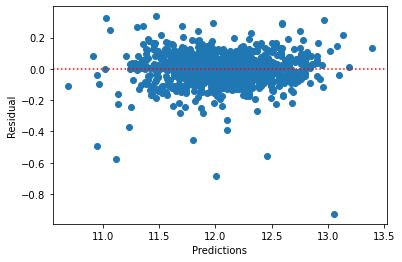

In [64]:
plt.scatter( y_pred , y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

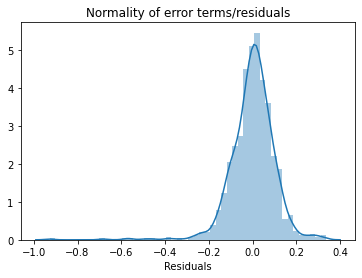

In [65]:
# Distribution of errors
p = sns.distplot(y_res,kde=True)

p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

### Ridge regression

In [66]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [67]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.5}


In [89]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 0.5
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-5.25725653e-02  2.77266972e-01  3.84575593e-01  3.66925359e-01
  1.91273690e-01  7.12081862e-02 -2.91279513e-02  7.93270612e-02
 -7.46510244e-03 -3.38282649e-02  1.57868281e-01  2.23288114e-01
  1.42940189e-02  2.31908093e-02  6.03725268e-01  4.34898543e-02
  3.02529899e-04  1.10690378e-01  5.63580322e-02  7.67806320e-02
 -1.54421370e-01  1.19210040e-01  7.54353750e-02  5.23651263e-02
  1.92583196e-01  3.10803384e-02  1.56145162e-02  1.49098814e-02
  1.92833041e-02  7.59368030e-02  6.05227199e-02  6.56233154e-02
 -2.54599983e-02  1.13905535e-01 -4.39175255e-03  1.86317784e-02
 -6.69502221e-02  8.86069357e-02  1.09334431e-02 -9.69085084e-03
  1.45232507e-02  6.79505979e-02  5.32775817e-02 -1.61344419e-02
  2.21795072e-02 -1.96282383e-02 -4.18484539e-02 -9.61858200e-02
 -6.27278579e-03 -1.93922818e-02 -1.84693578e-01  1.12442080e-01
  2.83134871e-02  3.58915495e-02  8.04646163e-03 -2.85009739e-03
  1.84197300e-02 -1.96599733e-02  4.09034070e-03 -6.95254919e-02
  5.03477606e-02  8.49477

In [90]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 value train: {}".format(r2_train_lr))
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 value test: {}".format(r2_test_lr))
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS value train: {}".format(rss1_lr))
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS value test: {}".format(rss2_lr))
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE value train: {}".format(mse_train_lr))
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE value test: {}".format(mse_test_lr))
metric2.append(mse_test_lr**0.5)

R2 value train: 0.9309499073849294
R2 value test: 0.8778533299638417
RSS value train: 10.938482180437408
RSS value test: 9.075991847473357
MSE value train: 0.010703015832130536
MSE value test: 0.020721442574140086


### Lasso Reg

In [72]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [73]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [94]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [95]:
lasso.coef_

array([-2.66902462e-02,  3.07087069e-01,  3.86526134e-01,  4.05176972e-01,
        2.36678020e-01,  6.53026365e-02, -8.52001083e-03,  6.97500943e-02,
       -1.25917869e-02, -2.92738677e-02,  1.81053831e-01,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.07150200e+00,  4.62492879e-02,
        0.00000000e+00,  7.17702500e-02,  4.49607099e-02,  2.89858796e-02,
       -1.63146095e-01,  7.10869081e-02,  6.75250261e-02,  4.49087204e-02,
        1.65156220e-01,  4.62976072e-02,  1.53327730e-02,  1.08845177e-02,
        1.49931563e-02,  5.31984837e-02,  5.35477746e-02,  1.26875508e-01,
       -1.90258580e-02,  0.00000000e+00, -2.90149936e-03,  2.76842795e-02,
       -5.04317194e-02,  6.65481308e-02,  2.79940696e-03, -0.00000000e+00,
        2.68423217e-02,  6.97366993e-02,  3.46880834e-02, -0.00000000e+00,
        1.57481721e-03, -8.22179985e-03, -1.81351868e-02, -7.06327775e-02,
       -0.00000000e+00, -4.32635273e-03, -2.08534175e-01,  8.00466499e-02,
       -0.00000000e+00,  

In [96]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 value train: {}".format(r2_train_lr))
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 value test: {}".format(r2_test_lr))
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS value train: {}".format(rss1_lr))
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS value test: {}".format(rss2_lr))
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE value train: {}".format(mse_train_lr))
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE value test: {}".format(mse_test_lr))
metric3.append(mse_test_lr**0.5)

R2 value train: 0.9323353615164546
R2 value test: 0.8846761405360678
RSS value train: 10.719007234705119
RSS value test: 8.569029413605548
MSE value train: 0.010488265395993268
MSE value test: 0.019563994094989837


In [97]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV


model = Lasso()

In [80]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.338408e-01,0.930950,0.932335
1,R2 Score (Test),-9.558889e+19,0.877853,0.884676
2,RSS (Train),1.048053e+01,10.938482,10.719007
3,RSS (Test),7.102641e+21,9.075992,8.569029
4,MSE (Train),1.012666e-01,0.103455,0.102412
5,MSE (Test),4.026919e+09,0.143949,0.139871


### The changes in the coefficients after regularization

In [82]:
betas = pd.DataFrame(index=X.columns)

In [83]:
betas.rows = X.columns

In [85]:
betas['Linear'] = lr.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [86]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
LotFrontage,-4.651426e-02,-0.052573,-0.026690
LotArea,3.271562e-01,0.277267,0.307087
OverallQual,3.566119e-01,0.384576,0.386526
OverallCond,4.231891e-01,0.366925,0.405177
YearBuilt,-1.878856e+08,0.191274,0.236678
YearRemodAdd,6.820345e-02,0.071208,0.065303
MasVnrArea,-3.469866e-02,-0.029128,-0.008520
BsmtFinSF1,8.793227e-02,0.079327,0.069750
BsmtFinSF2,-1.507164e-02,-0.007465,-0.012592
BsmtUnfSF,-4.079731e-02,-0.033828,-0.029274


In [ ]:
#Final model fit
#submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
#submission.iloc[:, 1].shape